%run "C:\Users\shiwei\Data Analysis\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Data Analysis")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

In [2]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

29172


# 0. required packages for h5py

In [3]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [4]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing',
             'save_folder':r'D:\Pu_Temp\20201221-acr\before_clearing',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 12,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

In [6]:
sel_fov_id = 5
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=sel_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201221-acr\before_clearing\Conv_zscan_05.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_im', 'ref_im'] in 1.728s.
+ loading correction from file: D:\Pu_Temp\20201221-acr\before_clearing\Conv_zscan_05.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201221-acr\before_clearing\Conv_zscan_05.hdf5
++

## 2. Process image into candidate spots

In [7]:
reload(io_tools.load)
reload(spot_tools.fitting)
reload(correction_tools.chromatic)
reload(classes.batch_functions)

# process image into spots
id_list, spot_list = fov._process_image_to_spots('unique', 
                                                 #_sel_ids=np.arange(41,47),
                                                 _load_common_reference=True,
                                                 _load_with_multiple=False,
                                                 _save_images=True,
                                                 _warp_images=False, 
                                                 _overwrite_drift=False,
                                                 _overwrite_image=False,
                                                 _overwrite_spot=False,
                                                 _verbose=True)

-- No folder selected, allow processing all 11 folders
-- checking unique, region:[45] in 0.004s.
-- checking unique, region:[96 97] in 0.003s.
-- checking unique, region:[ 99 100] in 0.003s.
-- checking unique, region:[102 103] in 0.003s.
-- checking unique, region:[105 106] in 0.003s.
-- checking unique, region:[108 109] in 0.003s.
-- checking unique, region:[111 112] in 0.003s.
-- checking unique, region:[114 113] in 0.003s.
-- checking unique, region:[98 95] in 0.003s.
-- checking unique, region:[104 101] in 0.003s.
-- checking unique, region:[110 107] in 0.003s.


# 3. Find chromosomes

## 3.1 load chromosome image

In [8]:
chrom_im = fov._load_chromosome_image(_type='forward', _overwrite=False)

directly return existing attribute.


<IPython.core.display.Javascript object>


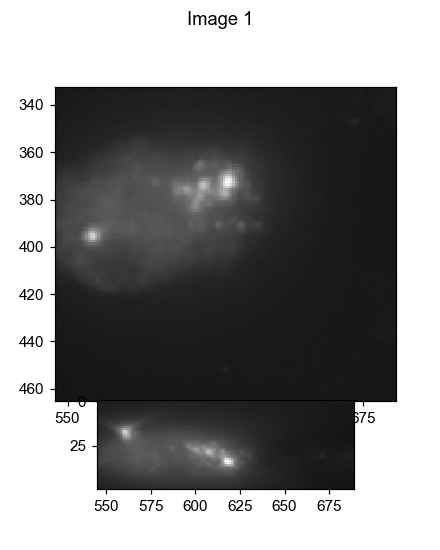

In [32]:
# visualize chromsome image:
visual_tools.imshow_mark_3d_v2([fov.chrom_im])

In [35]:
spots = spot_tools.fitting.fit_fov_image(fov.chrom_im, channel='750', th_seed=2000)

-- start fitting spots in channel:750, 500 seeded, 500 fitted in 98.869s.


## 3.2 find candidate chromosomes

In [10]:
chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4,
                                                               _binary_per_th=99.7, 
                                                               _morphology_size=2,
                                                               _overwrite=True)

-- adjust seed image with filter size=4
-- binarize image with threshold: 99.7%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.


E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 292 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 12 threads in 380.789s.
-- saving fov_info to file: D:\Pu_Temp\20201221-acr\before_clearing\Conv_zscan_05.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.025s.


## 3.3 select among candidate chromosomes

In [22]:
chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                         _cand_spot_intensity_th=200,
                                                         _save=True, 
                                                         _overwrite=True)

- start select from 292 chromosomes with loss threshold=0.5
-- remove chr id 33, percentage of lost rounds:0.905.
-- remove chr id 239, percentage of lost rounds:0.905.
-- remove chr id 156, percentage of lost rounds:0.810.
-- remove chr id 66, percentage of lost rounds:0.762.
-- remove chr id 191, percentage of lost rounds:0.762.
-- remove chr id 218, percentage of lost rounds:0.762.
-- remove chr id 178, percentage of lost rounds:0.714.
-- remove chr id 215, percentage of lost rounds:0.714.
-- remove chr id 134, percentage of lost rounds:0.667.
-- remove chr id 169, percentage of lost rounds:0.667.
-- remove chr id 246, percentage of lost rounds:0.667.
-- remove chr id 46, percentage of lost rounds:0.619.
-- remove chr id 87, percentage of lost rounds:0.619.
-- remove chr id 110, percentage of lost rounds:0.619.
-- remove chr id 147, percentage of lost rounds:0.619.
-- remove chr id 225, percentage of lost rounds:0.619.
-- remove chr id 69, percentage of lost rounds:0.571.
-- remove 

### visualize chromosomes selections

<IPython.core.display.Javascript object>


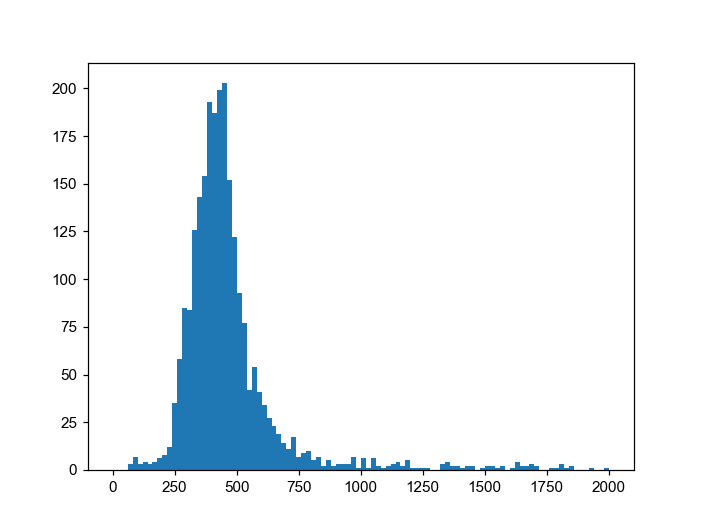

(array([  0.,   0.,   0.,   3.,   7.,   3.,   4.,   3.,   4.,   6.,   8.,
         12.,  35.,  58.,  85.,  84., 126., 143., 154., 193., 187., 199.,
        203., 152., 122.,  93.,  77.,  42.,  54.,  41.,  34.,  27.,  23.,
         19.,  14.,  11.,  17.,   7.,   9.,  10.,   5.,   7.,   2.,   5.,
          2.,   3.,   3.,   3.,   7.,   1.,   6.,   1.,   6.,   2.,   1.,
          2.,   3.,   4.,   2.,   5.,   1.,   1.,   1.,   1.,   0.,   0.,
          3.,   4.,   2.,   2.,   1.,   2.,   2.,   0.,   1.,   2.,   2.,
          1.,   2.,   0.,   1.,   4.,   2.,   2.,   3.,   2.,   0.,   0.,
          1.,   1.,   3.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
         540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
         720.,  740.,  760.,  780.

In [25]:
plt.figure()
plt.hist(fov.unique_spots_list[1][:,0],100, range=(0,2000))

In [28]:
from skimage.restoration import richardson_lucy

In [31]:
class psf_class(np.ndarray):
    def __init__():
        pass
    

def generate_psf(source_ims:list, 
                 channel:str,
                 ):
    pass


def deconvolve_RL(im:np.ndarray,
                  psf:psf_class,
                  process_2d:bool=True,
                 ):
    pass



<IPython.core.display.Javascript object>


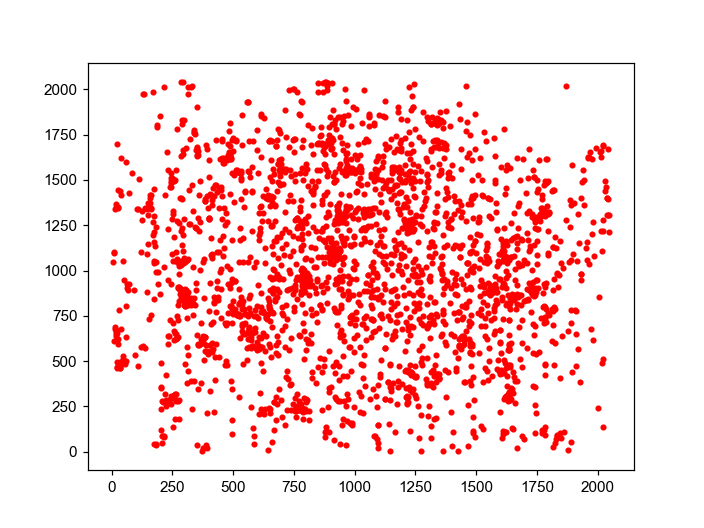

In [27]:
plt.figure()
plt.plot(fov.unique_spots_list[1][:,2], fov.unique_spots_list[1][:,3], 'r.')
plt.show()


<IPython.core.display.Javascript object>


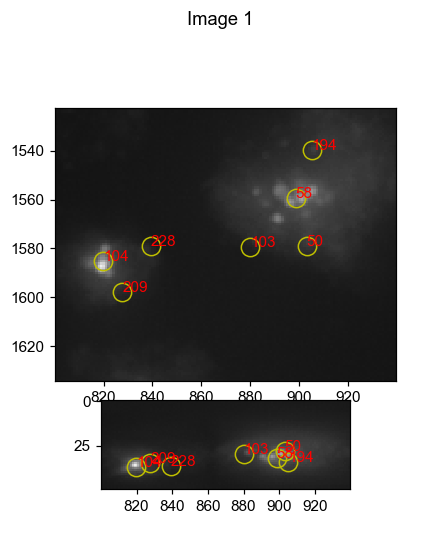

In [23]:
%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[np.flipud(_coord) for _coord in fov.chrom_coords],
              'class_ids':list(np.zeros(len(fov.chrom_coords),dtype=np.int)),
             }

visual_tools.imshow_mark_3d_v2([fov.chrom_im], 
                               given_dic=coord_dict,
                               save_file=None,
                               )


## select spots based on chromosomes

In [ ]:
fov._load_from_file('unique')

In [ ]:
intensity_th = 0.5
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

kept_spots_list = []
for _spots in fov.unique_spots_list:
    kept_spots_list.append(_spots[_spots[:,0] > intensity_th])
# finalize candidate spots
cand_chr_spots_list = [[] for _ct in fov.chrom_coords]
for _spots in kept_spots_list:
    _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
    for _i, _cands in enumerate(_cands_list):
        cand_chr_spots_list[_i].append(_cands)
print(f"kept chromosomes: {len(fov.chrom_coords)}")

In [ ]:
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys

dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

In [ ]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, fov.chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[_dists < dist_th])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

In [ ]:
reload(ia.spot_tools.picking)
# load functions
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,20,0.5))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,5000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.99:
        break

In [ ]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
distmap_list = []
score_th = np.exp(-6)
bad_spot_percentage = 0.6
for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _kept_hzxys[_scores < score_th] = np.nan
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

In [ ]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
#ax.set_xticks(np.arange(0,150,20))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"before clearing, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [ ]:
plt.figure()
for _reg_id in range(3):
    plt.hist(fov.unique_spots_list[_reg_id][:,0], bins=np.arange(0,4000,40), 
             label=f"{_reg_id}", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
plt.figure()
for _reg_id in range(3):
    plt.hist(fov.unique_spots_list[_reg_id][:,4], bins=np.arange(0,4000,40), 
             label=f"{_reg_id}", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
sel_ids = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos[:2]:
        if _info[0] == 'u':
            sel_ids.append(int(_info[1:]))
sel_ids = np.array(sel_ids)

In [ ]:
np.sort(sel_ids)

In [ ]:
sel_inds = np.sort([np.where(_id==fov.unique_ids)[0][0] for _id in sel_ids])

In [ ]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[sel_inds][:,sel_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"before clearing, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [ ]:
fov.unique_spots_list[0].shape